In [1]:
import nidaqmx as ni
from nidaqmx.constants import AcquisitionType, Level, WAIT_INFINITELY
from nidaqmx.types import CtrFreq
import numpy as np
import time
import matplotlib.pyplot as plt

output_mapping = [
    'Dev2/ao0', 
    'Dev2/ao1', 'Dev2/ao2', 'Dev2/ao3']
input_mapping = [
    'Dev2/ai0', 'Dev2/ai1', 'Dev2/ai2', 'Dev2/ai3',  'Dev2/ai4']
pixels = 2000
frequency = 5
samplerate = pixels*frequency
nsamples = pixels

data = np.array([
    np.concatenate([np.linspace(0,1, num=500), np.linspace(1,0, num=pixels-500)]),
    np.linspace(0,1, num=pixels),
    np.linspace(0,1, num=pixels),
    np.linspace(0,1, num=pixels)
])

with ni.Task() as read_task, ni.Task() as write_task, ni.Task() as co_task:
    for i, o in enumerate(output_mapping):
        aochan = write_task.ao_channels.add_ao_voltage_chan(
            o,
        )
       
    for i in input_mapping:
        read_task.ai_channels.add_ai_voltage_chan(i)

    
    write_task.timing.cfg_samp_clk_timing(
        rate=samplerate, source="OnboardClock", samps_per_chan=nsamples
    )

    read_task.timing.cfg_samp_clk_timing(
        rate=samplerate, source="OnboardClock", samps_per_chan=nsamples
    )

    # trigger write_task as soon as read_task starts
    write_task.triggers.start_trigger.cfg_dig_edge_start_trig(
        read_task.triggers.start_trigger.term)
    # squeeze as Task.write expects 1d array for 1 channel
    write_task.write(
        np.ascontiguousarray(data.squeeze()), 
                        auto_start=False)
    
    

    

    co_channel = co_task.co_channels.add_co_pulse_chan_freq(
         'Dev2/ctr0', idle_state=Level.LOW, initial_delay=0.0,  freq=frequency*pixels, duty_cycle=0.5)
    co_channel.co_pulse_term = '/Dev2/PFI0'


    co_task.timing.cfg_implicit_timing(
        sample_mode=AcquisitionType.FINITE,samps_per_chan=pixels)
    co_task.triggers.start_trigger.cfg_dig_edge_start_trig(
        read_task.triggers.start_trigger.term)
  

    start = time.time()
    # read_task.start()
    
    # write_task doesn't start at read_task's start_trigger without this
    write_task.start()
    co_task.start()
    # do not time out for long inputs
    # time.sleep(2)
    indata = read_task.read(nsamples, timeout=WAIT_INFINITELY)

    co_task.wait_until_done(timeout=20000)


In [2]:
len(indata[4])

2000

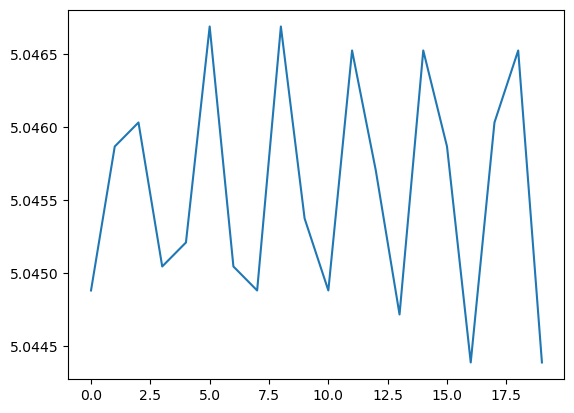

In [3]:
fig, ax = plt.subplots()
# plt.plot(indata[0])
# plt.plot(indata[1])
# plt.plot(indata[2])
plt.plot(indata[4][:20])

In [4]:
np.std(indata[4])

0.0007883985095739222

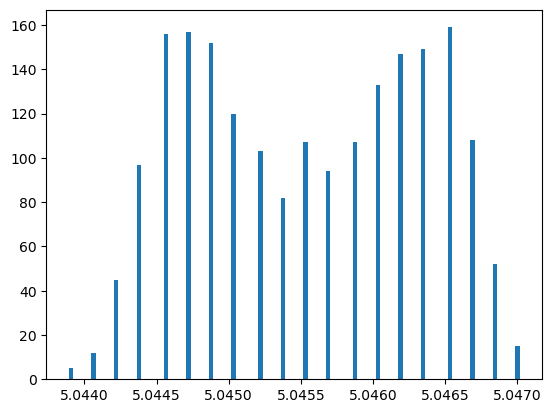

In [5]:
_ = plt.hist(indata[4], bins=100)